In [1]:
import os
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium
import contextily as ctx
import rasterio
from rasterio.plot import show
from rasterio.mask import mask 
from branca.colormap import LinearColormap
from IPython.display import display
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm

# Section 0: Configuration & Setup

GEOJSON_PATH = 'outputs/final_results/rooftop_solar_potential_optimized.geojson'
SHADE_TIF_PATH = 'outputs/final_results/shading_factor.tif'
OUTPUT_MAP_DIR = 'outputs/Fig'
os.makedirs(OUTPUT_MAP_DIR, exist_ok=True)

# Global Plotting Parameters
# Define a unified layout to ensure consistency across multiple figures
FIG_SIZE = (15, 12)
LEGEND_LOC = [0.92, 0.25, 0.02, 0.5] # [Left, Bottom, Width, Height]

# Custom Colormap Definition 
custom_maroon_cmap = 'RdYlGn_r'


# Section 1: Data Loading

if not os.path.exists(GEOJSON_PATH):
    print(f"Error: File not found: {GEOJSON_PATH}")
    exit()

print(f"Loading data: {GEOJSON_PATH}")
gdf = gpd.read_file(GEOJSON_PATH)

# Data Cleaning: Handle missing values
for col in ['potential_kwh', 'payback_years', 'yearly_savings', 'area_m2']:
    if col in gdf.columns:
        gdf[col] = gdf[col].fillna(0).astype(float)


# Section 2: Data Reclassification (Zoning Correction)

# Step 1: Initialize a clean zoning column
gdf['zoning_type_clean'] = gdf['zoning_type']

# Step 2: Define area threshold (Consistent with static analysis logic)
AREA_THRESHOLD_FOR_INSTITUTIONAL = 3000 

# Step 3: Identify outliers
# Assumption: Buildings > 3000 m² marked as 'Residential' are likely 'Institutional' or 'Hospital'
is_residential = gdf['zoning_type'].astype(str).str.contains('Resid', case=False, na=False)
is_oversized = gdf['area_m2'] > AREA_THRESHOLD_FOR_INSTITUTIONAL

outlier_mask = is_residential & is_oversized

# Step 4: Apply reclassification
if outlier_mask.any():
    gdf.loc[outlier_mask, 'zoning_type_clean'] = 'Institutional/Hospital'
    print(f"Successfully reclassified {outlier_mask.sum()} large institutional buildings (outliers).")
else:
    print("No residential outliers found requiring reclassification.")


# Section 3: Coordinate Systems & Map Bounds

# Ensure Web Mercator (EPSG:3857) for Contextily basemaps
if gdf.crs.to_string() != 'EPSG:3857':
    gdf_web = gdf.to_crs(epsg=3857)
else:
    gdf_web = gdf

# Create WGS84 copy for potential Folium usage
gdf_ll = gdf.to_crs(epsg=4326)

# Calculate Unified Map Bounds (Web Mercator)
# This locks the zoom level and extent for all subsequent static maps
minx, miny, maxx, maxy = gdf_web.total_bounds
pad = 150 # 150 meter padding
WEB_LIMITS = (minx - pad, maxx + pad, miny - pad, maxy + pad)

print(f"Data loaded successfully. Total roofs: {len(gdf)}. Starting visualization sequence...")


# Section 4: Plotting Function

def plot_static_map(gdf, column, title, cmap, legend_label, output_name, vmax=None):
    """
    Generates and saves a static map with consistent styling and bounds.
    """
    print(f"   Generating plot: {title} ...")
    
    # Use global figure size
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Use global legend position
    cax = fig.add_axes(LEGEND_LOC) 

    plot_kwargs = {
        'column': column,
        'ax': ax,
        'legend': True,
        'cax': cax,
        'legend_kwds': {'label': legend_label, 'orientation': "vertical"},
        'cmap': cmap,
        'alpha': 0.9,           
        'edgecolor': 'black',  
        'linewidth': 0.3
    }
    if vmax: plot_kwargs['vmax'] = vmax

    gdf.plot(**plot_kwargs)
    
    # Enforce unified map bounds
    ax.set_xlim(WEB_LIMITS[0], WEB_LIMITS[1])
    ax.set_ylim(WEB_LIMITS[2], WEB_LIMITS[3])
    
    # Add Basemap (CartoDB Positron)
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=16)
    except Exception as e:
        print(f"      Warning: Could not load basemap. {e}")

    ax.set_title(title, fontsize=22, pad=20)
    ax.set_axis_off()
    
    save_path = os.path.join(OUTPUT_MAP_DIR, output_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='pdf')
    print(f"      Saved: {save_path}")
    plt.show() 
    plt.close(fig)

Loading data: outputs/final_results/rooftop_solar_potential_optimized.geojson
Successfully reclassified 7 large institutional buildings (outliers).
Data loaded successfully. Total roofs: 4608. Starting visualization sequence...



Starting final figure generation...

Generating paper-ready composite figure (2x2 Layout with data cleaning)...
   Color scale range (Vmax): 17.43 years
   [Cleaning] (b) Residential Buildings: Removed 7 outliers > 3000m² (likely institutional).
✅ Composite figure saved: outputs/Fig\Fig_Spatial_Distribution_of_Payback_Years_by_Building_Type.pdf


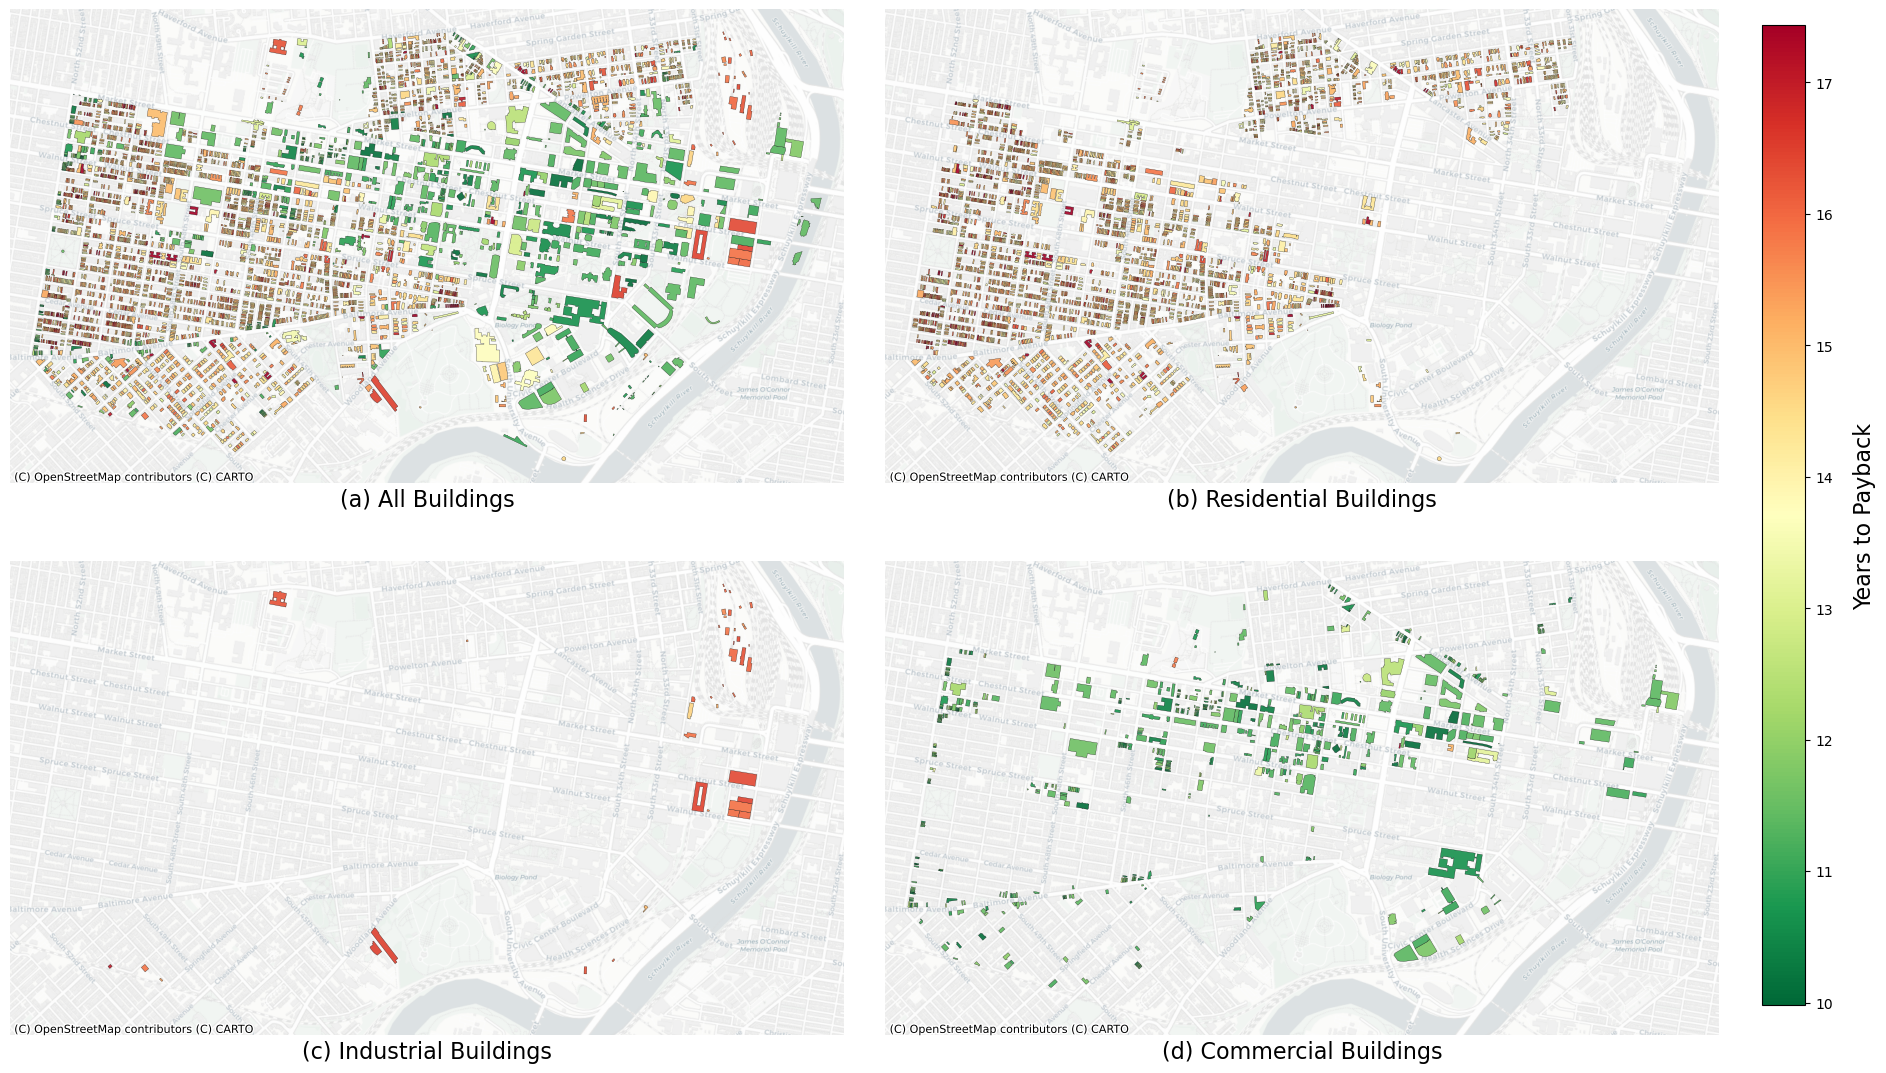


Process Complete! Please check the output folder.


In [2]:
def plot_paper_composite_figure_refined(gdf, zoning_col='zoning_type'):
    print("\nGenerating paper-ready composite figure (2x2 Layout with data cleaning)...")
    
    # 1. Configure Global Color Parameters
    # Using the 98th percentile for vmax helps visualize the distribution better 
    # by mitigating the skew caused by extreme outliers (e.g., massive institutional roofs).
    plot_col = 'payback_years' 
    vmin = gdf[plot_col].min()
    vmax = np.percentile(gdf[plot_col].replace([np.inf, -np.inf], np.nan).dropna(), 98)
    
    # Safety check: Ensure vmax is valid
    if vmax <= vmin:
        vmax = gdf[plot_col].max() # Fallback to max if percentile method fails
        
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    print(f"   Color scale range (Vmax): {vmax:.2f} years")
    
    # 2. Initialize Figure (2 rows, 2 columns)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21.5, 14))
    ax_flat = axes.flatten()
    
    # 3. Define Plot Configurations (Top-Left, Top-Right, Bottom-Left, Bottom-Right)
    plot_configs = [
        # (a) ALL - Top Left
        {"title": "(a) All Buildings", "filter": "ALL", "ax": ax_flat[0], "max_area": None},
        
        # (b) Residential - Top Right: Apply area filter
        # 3000 m² is a conservative threshold to exclude large hospitals/institutions mislabeled as residential.
        {"title": "(b) Residential Buildings", "filter": "Resid", "ax": ax_flat[1], "max_area": 3000},
        
        # (c) Industrial - Bottom Left
        {"title": "(c) Industrial Buildings", "filter": "Indust", "ax": ax_flat[2], "max_area": None},
        
        # (d) Commercial - Bottom Right
        {"title": "(d) Commercial Buildings", "filter": "Commer", "ax": ax_flat[3], "max_area": None}
    ]

    # 4. Iterative Plotting Loop
    for config in plot_configs:
        ax = config["ax"]
        filter_str = config["filter"]
        
        # --- Data Filtering Logic ---
        if filter_str == "ALL":
            subset = gdf.copy()
        else:
            # Filter by string containment (case-insensitive)
            subset = gdf[gdf[zoning_col].astype(str).str.contains(filter_str, case=False, na=False)]
        
        # --- Secondary Filter: Clean Residential Outliers ---
        if config["max_area"] is not None and not subset.empty:
            original_count = len(subset)
            # Filter out "pseudo-residential" buildings that are too large
            subset = subset[subset['area_m2'] < config['max_area']]
            dropped_count = original_count - len(subset)
            
            if dropped_count > 0 and filter_str == "Resid":
                print(f"   [Cleaning] {config['title']}: Removed {dropped_count} outliers > {config['max_area']}m² (likely institutional).")

        # --- Plotting ---
        if not subset.empty:
            subset.plot(
                column=plot_col,
                ax=ax,
                cmap=custom_maroon_cmap, 
                norm=norm,                
                alpha=0.9,
                edgecolor='black',
                linewidth=0.2
            )
        else:
            ax.text(0.5, 0.5, 'No Data Found or All Filtered Out', ha='center', transform=ax.transAxes)

        # --- Standardize Basemap and Extents ---
        # Enforce the same global map limits (calculated in previous steps)
        ax.set_xlim(WEB_LIMITS[0], WEB_LIMITS[1])
        ax.set_ylim(WEB_LIMITS[2], WEB_LIMITS[3])
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=15, alpha=0.8)
        except: pass
            
        # Position Title at Bottom Center
        # (0.5, -0.01) places the text just below the X-axis
        ax.text(
            0.5, 
            -0.01, 
            config["title"], 
            transform=ax.transAxes,
            fontsize=16, 
            ha='center', 
            va='top',    
        )
        ax.set_axis_off()

    # 5. Add Shared Colorbar
    plt.subplots_adjust(right=0.92, wspace=0.05, hspace=0.05)
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7]) 
    sm = plt.cm.ScalarMappable(cmap=custom_maroon_cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Years to Payback', fontsize=16, labelpad=15)
    
    save_path = os.path.join(OUTPUT_MAP_DIR, 'Fig_Spatial_Distribution_of_Payback_Years_by_Building_Type.pdf')
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='pdf')
    print(f"✅ Composite figure saved: {save_path}")
    plt.show()


# Execute Plotting Logic
print("\nStarting final figure generation...")
plot_paper_composite_figure_refined(gdf_web, zoning_col='zoning_type')

print("\nProcess Complete! Please check the output folder.")